In [1]:
import glob
import os

import netCDF4 as nc4
import numpy as np

from src.loader import get_most_frequent_label
from src.metrics import hist1D_per_class

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
channel = "cloud_water_path"
bins = np.linspace(0, 5000, 1000)

data_paths = glob.glob("../DATA/nc/*.nc")
prediction_dir = "results/lgbm/predicted-label-masks/"

In [3]:
def load_files():
    
    for nc_file in data_paths:

        base = os.path.basename(nc_file)
        base_npy = base.replace(".nc", ".npy")

        predictions = np.load(os.path.join(prediction_dir, base_npy))

        file = nc4.Dataset(nc_file, 'r', format='NETCDF4')

        properties = file.variables[channel][0]
        rois = file.variables["cloud_mask"][0]
        labels = file.variables["cloud_layer_type"][0]

        file.close()

        yield properties, rois.data, labels.data, predictions

In [4]:
hists, counts = hist1D_per_class(load_files, bins)
# normalize histograms
hists["target"] = np.divide(hists["target"], counts["target"], out=np.zeros_like(hists["target"]), where= counts["target"] > 0)
hists["pred"] = np.divide(hists["pred"], counts["pred"], out=np.zeros_like(hists["pred"]), where= counts["pred"] > 0)

In [5]:
hists

{'target': array([[0.        , 0.02202643, 0.03964758, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.01652893, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.07017544, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'pred': array([[6.07358564e-03, 3.41948545e-02, 5.45053305e-02, ...,
         7.24339372e-06, 3.62169686e-06, 8.45062601e-06],
        [1.46957520e-03, 5.60693038e-03, 1.01158543e-02, ...,
         4.17492955e-06, 0.00000000e+00, 4.17492955e-06],
        [1.40566659e-03, 2.17146204e-02, 3.43363350e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [5.5406351

/home/vale/.local/lib/python3.6/site-packages/seaborn/distributions.py:366: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


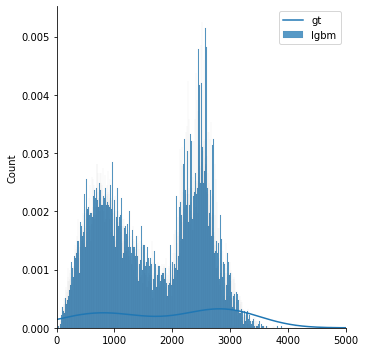

In [34]:
# plot target and prediction histograms for class 7
cl = 7
sns.displot(x=bins[1:], bins=bins, kde=False, weights=hists["pred"][cl], label="lgbm") # plot histogram for preditions
sns.kdeplot(x=bins[1:], weights=hists["target"][cl], hue_norm=False, label="gt") # plot density for ground-truth

plt.xlim(0, 5000)
plt.legend()